# Inverse DeepONet
In this notebook, we present the learning of the inverse operator, that maps solution data to some input data. 
To keep things simple we again consider the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}
for different functions, $f$. (Learning the differential operator)

For a non physics DeepONet one needs a data pair of input data and expected solution, for the training of the inverse operator.
The training would then consist of a fitting procedure.

If we want to include physics into the training's loss, one generally needs some derivatives of the solution (which is only given by discrete values). To compute them, one can either apply some finite difference scheme or use one additional DeepONet to first interpolate the data and then train a second network for the inverse operator using the first DeepONet and a physics loss.

Here we demonstrate the first option. The physics informed inverse DeepONet will be shown in a different example.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import numpy as np
import torchphysics as tp
import pytorch_lightning as pl

The generall parameter and variable definition is the same as in the forward problem:

In [2]:
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # function output space name
K = tp.spaces.R1('k') # parameter
F = tp.spaces.R1('f') # output variable
# Domains
T_int = tp.domains.Interval(T, 0, 1)
K_int = tp.domains.Interval(K, 0, 6) # Parameters will be scalar values (need to create some training data)

In [3]:
# Defining function set
Fn_space = tp.spaces.FunctionSpace(T_int, U)

# Here some rhs functions that we consider in our example and network should output
def f1(k, t):
    return k*t

def f2(k, t):
    return k*t**2

def f3(k, t):
    return k*torch.cos(k*t)

In [4]:
# Model
dis_sampler = tp.samplers.GridSampler(T_int, 50).make_static()
trunk_net = tp.models.FCTrunkNet(T, F, hidden=(30, 30), output_neurons=50)
branch_net = tp.models.FCBranchNet(Fn_space, F, output_neurons=50, 
                                   hidden=(50, 50), 
                                   discretization_sampler=dis_sampler)
model = tp.models.DeepONet(trunk_net, branch_net)

Now we create some data, consisting of data functions (the defined **f** above) and the expected solutions of our ODE. For our example, we can compute them analytically.

We evaluate both the solution functions only at the points of the discretization sampler, such they can be used as the branch input, while the data functions could be evaluated at arbitrary points in the interval.

If the corresponding data would be available in some different kind of manner (e.g. measurements), one would skip this step.

In [5]:
# create evaluation points
eval_points = dis_sampler.sample_points().as_tensor
time_sampler = tp.samplers.GridSampler(T_int, n_points=1000)
trunk_input_points = time_sampler.sample_points().as_tensor
# Define expected solutions for the rhs of cell 3 (the different f functions)
def u1(k, t):
    return k/2.0 * t**2

def u2(k, t):
    return k/3.0 * t**3

def u3(k, t):
    return torch.sin(k*t)

# create some dataset:
num_data_points = 50000 # number of different data pairs
f_list = [f1, f2, f3]
u_list = [u1, u2, u3]
param_sampler = tp.samplers.RandomUniformSampler(K_int, n_points=num_data_points)
u_data_tensor = torch.zeros((num_data_points, len(eval_points), 1)) # tensor for the solution
f_data_tensor = torch.zeros((num_data_points, len(trunk_input_points), 1)) # tensor for the rhs

param_tensor = param_sampler.sample_points().as_tensor
data_idx = 0
for param in param_tensor:
    rand_idx = np.random.randint(0, 3) # pick one of our the functions
    # evaluate the functions
    u_data_tensor[data_idx] = u_list[rand_idx](param, eval_points)
    f_data_tensor[data_idx] = f_list[rand_idx](param, trunk_input_points)
    data_idx += 1

Now some data is available, which can be used to train the inverse operator. For a data fitting task the **tp.utils.DeepONetDataLoader** and **tp.conditions.DeepONetDataCondition** are available. 

The Dataloader needs the data inputs in the follwing structure:

   - branch_data: A tensor containing the branch inputs in the shape [number of data functions, input dim of Branchnet, dimension of function space]
   - trunk_data: A tensor containing the input data for the trunk network. Here are two different shapes possible:

      1) Every branch input function uses the same trunk values, then we can pass in
               the shape: [number of trunk points, input dimension of trunk net]
               This can speed up the trainings process. And is possible in our case.
      2) Or every branch function has different input values for the trunk net, then we 
         need the shape: 
         [number of data functions, number of trunk points, input dimension of Trunknet]
         If this is the case, remember to set **trunk_input_copied = false** inside
         the trunk net, to get the right trainings process.    
   - output_data : A tensor containing the expected output of the network. The shape of the data should be: 
        [number of data functions, number of trunk points, expected output dimension].

Our previously created data is already in the correct shape.

In [6]:
data_loader = tp.utils.DeepONetDataLoader(branch_data=u_data_tensor, trunk_data=trunk_input_points, 
                                          output_data=f_data_tensor, branch_space=U, trunk_space=T, 
                                          output_space=F, branch_batch_size=25000, trunk_batch_size=len(eval_points),
                                          shuffle_trunk = False)

# The DataCondition then handles everything for the training, just like in the PINN case.
# Via the keyword "norm" and "root" we can specify which norm should be used for computing the loss. Here we apply the L2 norm.
data_condition = tp.conditions.DeepONetDataCondition(model, data_loader, norm=2, root=2)


Now we can start the trainig

In [7]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.0005)

solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=10000,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarnin

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [8]:
optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.00005)

solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=1000,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

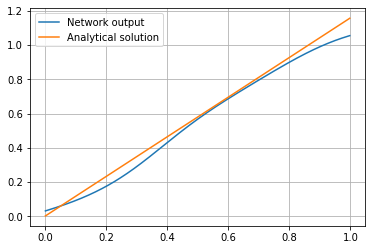

In [9]:
import matplotlib.pyplot as plt

# some parameter value
k0 = 1.16
def u(t):
    return k0/2.0 * t**2

def f(t):
    return k0 * t

model.fix_branch_input(u)
grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points().as_tensor
out = model(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]

grid_p = grid_points
plt.plot(grid_p, out)
plt.plot(grid_p, f(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])

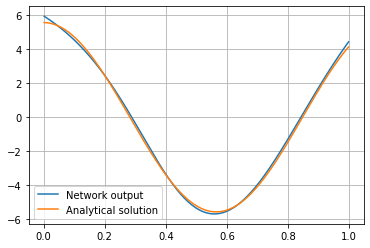

In [10]:
import matplotlib.pyplot as plt

# some parameter value
k0 = 5.56
def u(t):
    return torch.sin(k0 * t)

def f(t):
    return k0 * torch.cos(k0 * t)

model.fix_branch_input(u)
grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points().as_tensor
out = model(tp.spaces.Points(grid_points, T)).as_tensor.detach()[0]

grid_p = grid_points
plt.plot(grid_p, out)
plt.plot(grid_p, f(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])